In [4]:
import networkx as nx
import igraph as igraph
import community
import numpy as np
%matplotlib inline
#from infomap import infomap
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [5]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    infomapWrapper = infomap.Infomap("--two-level --silent")

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges():
        infomapWrapper.addLink(*e)

    print("Find communities with Infomap...")
    infomapWrapper.run();

    tree = infomapWrapper.tree

    print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

    communities = {}
    for node in tree.leafIter():
        communities[node.originalLeafIndex] = node.moduleIndex()

    nx.set_node_attributes(G, name='community', values=communities)
    return tree.numTopModules()

# lo saqué de acá:
# https://github.com/mapequation/infomap/blob/master/examples/python/infomap-examples.ipynb

In [6]:
# Funcion que paso Agus
def clusterize(nx_Graph, method="infomap"):
    """
    Calcula el agrupamiento en comunidades de un grafo.
    
    In:
        nx_Graph: grafo de networkx
        method: metodo de clustering, puede ser: "infomap", "fastgreedy", "eigenvector", "louvain", "edge_betweenness","label_prop", "walktrap", ""
        
    Out:
        labels_dict: diccionario de nodo : a label al cluster al que pertenece.
    """
    if method == "edge_betweenness":
        nx_Graph = max(nx.connected_component_subgraphs(nx_Graph), key=len)#se queda con la componente más grande.
        print("AVISO: restringiendo a la componente connexa más grade. De otro modo falla el algoritmo de detección de comunidades edge_betweenness.")
    
    isdirected = nx.is_directed(nx_Graph)
    np_adj_list = nx.to_numpy_matrix(nx_Graph)
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership
    if method=="label_prop":
        labels = g.community_label_propagation(weights="weight").membership
    if method=="fastgreedy":
        labels = g.community_fastgreedy(weights="weight").as_clustering().membership
    if method=="eigenvector":
        labels = g.community_leading_eigenvector(weights="weight").membership
    if method=="louvain":
        labels = g.community_multilevel(weights="weight").membership
    if method=="edge_betweenness":
        labels = g.community_edge_betweenness(weights="weight", directed=isdirected).as_clustering().membership
    if method=="walktrap":
        labels = g.community_walktrap(weights="weight").as_clustering().membership
    
    label_dict = {node:label for node,label in zip(nx_Graph.nodes(), labels)}
    return label_dict

In [73]:
def drawNetwork(G):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    print(communities)
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(nx.get_node_attributes(G, 'community')[n])
        )

    plt.axis('off')
    plt.show()

### Cargamos los datos y el sexo

In [42]:
red_delf = nx.read_gml('./Datos/dolphins.gml')
gen_delf = open('./Datos/dolphinsGender.txt').readlines()
    
sex_delf = []   
for i in range(len(gen_delf)):
    a = gen_delf[i].rstrip('\n').split('\t')
    sex_delf.append(a)

def atributoNodos(r, alist, atributo):

    for idx, nodo in enumerate(np.array(alist).transpose()[0]):
        r.nodes[nodo][atributo] = np.array(alist).transpose()[1][idx]

atributoNodos(red_delf, sex_delf, 'sexo')

In [43]:
# Pequeña observación: Hay delfines de los cuales no conocemos el sexo
# tenemos que decidir que vamos a hacer con eso --> borrarlos?

### Ejercicio 1 - Cálculo de clusters

[3, 0, 3, 4, 2, 0, 0, 0, 4, 0, 3, 2, 1, 0, 1, 2, 1, 0, 2, 0, 3, 2, 0, 2, 2, 0, 0, 0, 3, 2, 3, 0, 0, 1, 1, 2, 4, 1, 1, 4, 1, 0, 3, 1, 3, 2, 1, 3, 0, 1, 1, 2, 1, 1, 0, 2, 0, 0, 1, 4, 0, 1]


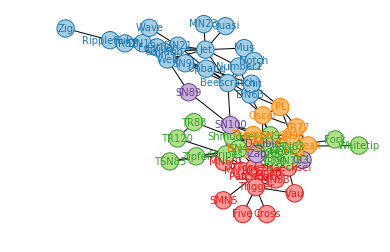

In [74]:
comus_infomap = clusterize(red_delf, "infomap") #List
nx.set_node_attributes(red_delf, name='community', values=comus_infomap)
drawNetwork(red_delf)

[0, 1, 0, 4, 4, 3, 3, 1, 4, 3, 0, 4, 2, 3, 2, 4, 2, 3, 4, 1, 2, 4, 3, 4, 4, 1, 1, 1, 1, 4, 1, 3, 3, 2, 2, 4, 2, 2, 2, 2, 2, 3, 0, 2, 2, 4, 2, 0, 3, 2, 2, 4, 2, 0, 3, 4, 3, 3, 2, 4, 3, 0]


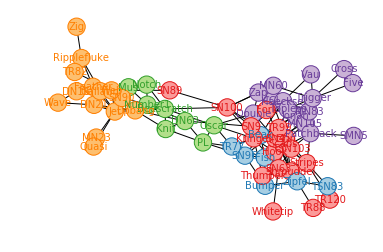

In [75]:
comus_louvain = clusterize(red_delf, "louvain") #List
nx.set_node_attributes(red_delf, name='community', values=comus_louvain)
drawNetwork(red_delf)

AVISO: restringiendo a la componente connexa más grade. De otro modo falla el algoritmo de detección de comunidades edge_betweenness.
[4, 0, 4, 1, 3, 0, 0, 0, 1, 0, 4, 3, 1, 0, 1, 3, 1, 0, 3, 0, 1, 3, 0, 3, 3, 0, 0, 0, 4, 3, 4, 0, 0, 1, 1, 3, 1, 1, 1, 0, 1, 0, 4, 1, 1, 3, 1, 4, 0, 1, 1, 3, 1, 2, 0, 3, 0, 0, 1, 1, 0, 2]


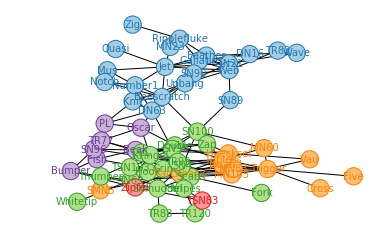

In [76]:
comus_edgeb = clusterize(red_delf, "edge_betweenness") #List
nx.set_node_attributes(red_delf, name='community', values=comus_edgeb)
drawNetwork(red_delf)

[0, 1, 0, 2, 2, 1, 1, 1, 2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 2, 1, 0, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 3, 0, 0, 3, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 1, 2, 1, 1, 0, 2, 1, 0]


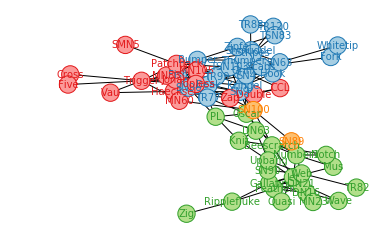

In [77]:
comus_fg = clusterize(red_delf, "fastgreedy") #List
nx.set_node_attributes(red_delf, name='community', values=comus_fg)
drawNetwork(red_delf)

***
#### No le den bola todavia a esto

In [34]:
from bokeh.io import show, output_file
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, BoxZoomTool, ResetTool
from bokeh.models.graphs import from_networkx
from bokeh.palettes import Spectral4
from bokeh.io import show, output_file
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4

G = nx.karate_club_graph()

SAME_CLUB_COLOR, DIFFERENT_CLUB_COLOR = "black", "red"
edge_attrs = {}

for start_node, end_node, _ in G.edges(data=True):
    edge_color = SAME_CLUB_COLOR if G.nodes[start_node]["club"] == G.nodes[end_node]["club"] else DIFFERENT_CLUB_COLOR
    edge_attrs[(start_node, end_node)] = edge_color

nx.set_edge_attributes(G, edge_attrs, "edge_color")

# Show with Bokeh
plot = Plot(plot_width=400, plot_height=400,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Graph Interaction Demonstration"

node_hover_tool = HoverTool(tooltips=[("index", "@index")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(red_delf, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
#graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)

output_file("interactive_graphs.html")
show(plot)